测试专家logits

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"
import sys
sys.path.append("/data2/lz/On-the-Fly_MoE_Inference/quantize")
from transformers import MixtralForCausalLM as MixtralTeacher
from modeling_mixtral import MixtralForCausalLM, load_thresholds, set_profile_mode
from transformers import AutoTokenizer, MixtralConfig
# from peft import LoraConfig, get_peft_model, PeftModel

import json
import torch

with open("../quantize/device_map.json", "r") as f:
	sd = json.load(f)

with open("../quantize/device_map.json", "r") as f:
	td = json.load(f)

def prepare_model(model_name, is_eval=False, has_atten=False, sparsity=80):
	config = MixtralConfig(use_cache=False, output_hidden_states=True)
	if is_eval:
		# set_teacher_sparsity(50,'c4')
		model = MixtralTeacher.from_pretrained(
			pretrained_model_name_or_path=model_name,
			config=config,
			torch_dtype=torch.bfloat16,
			device_map=td,
			)
		### 加载lora_path：bagel训练的
		# lora_path_teacher = '/home/bcds/On-the-Fly_MoE_Inference/quantize/saved/training/bagel0/checkpoint-1200'
		# #### 加载lora模型并merge
		
		# print(f"load lora model: {lora_path_teacher}")
		# model = PeftModel.from_pretrained(model, lora_path_teacher, adapter_name=f"load_teacher")
		# model.set_adapter(f"load_teacher")
		# model = model.merge_and_unload()
		model.eval()
	else:
		set_profile_mode(mode=False)
		load_thresholds("/home/bcds/On-the-Fly_MoE_Inference/saving/threshold/c4_mixtral/thresholds_0_5.pt", use_average=False)
		model = MixtralForCausalLM.from_pretrained(
			pretrained_model_name_or_path=model_name,
			config=config,
			torch_dtype=torch.bfloat16,
			device_map=sd,
		)
		# lora_path_student="/home/bcds/On-the-Fly_MoE_Inference/quantize/output/mixtral/90_10000_expert_atten/1"
		# print(f"load lora model: {lora_path_student}")
		# model = PeftModel.from_pretrained(model, lora_path_student, adapter_name=f"load_teacher")
		# model.set_adapter(f"load_teacher")
		# model = model.merge_and_unload()
		# print(f"set sparsity to {sparsity}")
		# ### 包装lora模块
		# rank = 32
		# target_modules = ["w1","w2","w3"]
		# if has_atten:
		# 	target_modules += ["q_proj","k_proj","v_proj","o_proj",]
		# peft_config = LoraConfig(
		# 	lora_alpha=32,
		# 	lora_dropout=0.01,
		# 	r=rank,
		# 	bias="none",
		# 	target_modules=target_modules,
		# 	task_type="CAUSAL_LM"
		# )

		# model = get_peft_model(model, peft_config) 
		# for name,param in model.named_parameters():
		# 	if not any(nd in name for nd in ["lora_A","lora_B"]):
		# 		param.requires_grad = False
		# 	else:
		# 		param.requires_grad = True
	return model

model_name = "mixtral"
dataset_name = "fineweb"
with open('../path.json', 'r') as file:
    paths = json.load(file)
    model_name = paths.get(model_name, '')
    fineweb_path = paths.get(dataset_name,)

sparsity = 0.5
## 用这个去画一下余弦相似度的图
teacher = prepare_model(model_name, is_eval=True)
# student = prepare_model(model_name, is_eval=False, has_atten=True, sparsity=sparsity)

/home/lz/miniconda3/envs/hqq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lz/miniconda3/envs/hqq/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 19/19 [00:33<00:00,  1.75s/it]


In [2]:
from datasets import load_dataset

fineweb = load_dataset("json", data_files=fineweb_path)
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = fineweb["train"]["text"][:30]
tokenizer.pad_token = tokenizer.eos_token
# print(texts)

In [8]:
import torch.nn as nn
def expert_logits_loss(logits, teacher_logits, attention_mask, criterion=nn.KLDivLoss()):
	expert_loss = torch.tensor(0.0)
	for layerid in range(2, 32):
		tensor1 = logits[layerid]
		tensor2 = teacher_logits[layerid]

		# print(tensor1.shape)
		mask = attention_mask.unsqueeze(-1).expand_as(tensor1)
		# print(mask.shape)
		masked_tensor1 = tensor1 * mask
		masked_tensor2 = tensor2 * mask
		
		tensor1 = F.softmax(tensor1, dim=0)
		tensor2 = F.softmax(tensor2, dim=0)
		expert_loss += criterion(tensor1.log(), tensor2)

	return expert_loss
import torch.nn.functional as F

for text in texts:
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs["labels"] = inputs.input_ids.clone()
    output = student(**inputs)

    t_output = teacher(**inputs)

    tensor1 = output["router_logits"]
    tensor2 = t_output["router_logits"]
    attention_mask = inputs["attention_mask"].squeeze(0)
    print(attention_mask.size(), attention_mask.sum())
    dl = expert_logits_loss(tensor1, tensor2, attention_mask).detach()
    print("expert_loss", dl.item())
    print("norm_loss", output["loss"].detach())

In [4]:
import torch.nn.functional as F
# spar_model_logits = []
def compute_cosine_sim_mean(x, next=1):
    # 去除大小为 1 的维度
    x = x.squeeze(1)  # 形状变为 (33, 256, 4096)

    # 计算余弦相似度
    current = x[next:]  # 形状 (32, 256, 4096)
    previous = x[:-next]  # 形状 (32, 256, 4096)
    cosine_sim = F.cosine_similarity(current, previous, dim=2)  # 形状 (32, 256)

    # 在 256 的维度上求平均值
    cosine_sim_mean = torch.mean(cosine_sim, dim=1)  # 形状 (32,)
    return cosine_sim_mean

results = []
for text in texts:
    print(len(results))
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs["labels"] = inputs.input_ids.clone()
    # output = student(**inputs)
    output = teacher(**inputs)

    tensor1 = output["hidden_states"]

    # 将当前元素转换为张量
    x = torch.stack(tensor1, dim=0).detach()  # 形状变为 (33, 1, 256, 4096)

    # 计算余弦相似度
    result = compute_cosine_sim_mean(x, next=1)  # 你可以根据需要调整 next 的值
    results.append(result.cpu())
    del x,tensor1
    torch.cuda.empty_cache()

# 将所有结果堆叠成一个张量
results = torch.stack(results)  # 形状 (129, 32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [5]:
# 对所有结果求平均值
final_mean = torch.mean(results, dim=0)  # 形状 ()

# 打印结果
# print(results.shape)  # 输出: torch.Size([129, 32])
print(final_mean[:-1])  # 输出最终的全局平均值

tensor([0.4395, 0.8242, 0.9492, 0.9570, 0.9609, 0.9648, 0.9688, 0.9727, 0.9766,
        0.9766, 0.9766, 0.9805, 0.9844, 0.9805, 0.9805, 0.9766, 0.9609, 0.9727,
        0.9727, 0.9805, 0.9844, 0.9883, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922,
        0.9844, 0.9766, 0.9453, 0.9141], dtype=torch.bfloat16)


In [12]:
## (layer+1, batch, seq, hidden_dim)
len(spar_model_logits[0]), len(spar_model_logits[0][0]), len(spar_model_logits[0][0][0]), len(spar_model_logits[0][0][0][0])

(33, 1, 256, 4096)

In [6]:
similarity2 = [0.2354, 0.7617, 0.9141, 0.9258, 0.9297, 0.9414, 0.9492, 0.9531, 0.9570,
        0.9609, 0.9609, 0.9688, 0.9688, 0.9688, 0.9609, 0.9375, 0.9180, 0.9375,
        0.9453, 0.9609, 0.9727, 0.9766, 0.9805, 0.9805, 0.9805, 0.9805, 0.9727,
        0.9492, 0.8945, 0.7852]
import numpy as np
np.average(lst)

np.float64(0.9519451612903228)

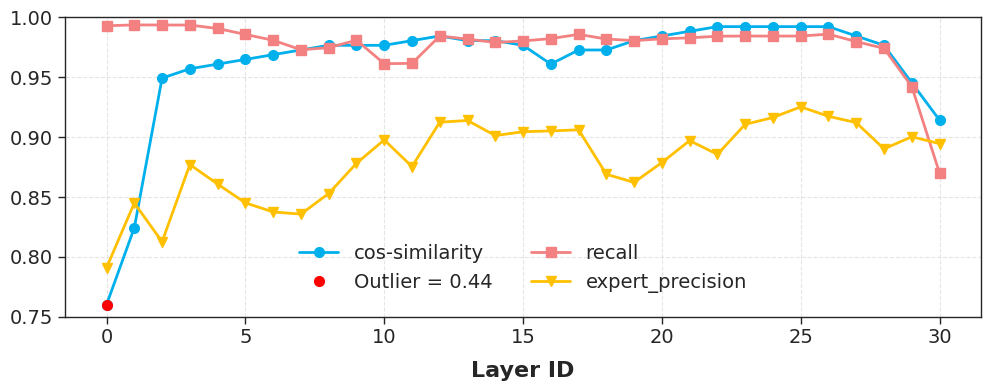

In [20]:
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Calibri']})
import matplotlib.pyplot as plt

# 数据
similarity = [0.4395, 0.8242, 0.9492, 0.9570, 0.9609, 0.9648, 0.9688, 0.9727, 0.9766,
        0.9766, 0.9766, 0.9805, 0.9844, 0.9805, 0.9805, 0.9766, 0.9609, 0.9727,
        0.9727, 0.9805, 0.9844, 0.9883, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922,
        0.9844, 0.9766, 0.9453, 0.9141]


recalls = [0.9929167207616273,
 0.993652953224467,
 0.9935663523101625,
 0.9935381470963337,
 0.9906454216999487,
 0.9856903147916639,
 0.9808128588026573,
 0.9728984419980262,
 0.974595306383042,
 0.9808898134666808,
 0.9612637478555939,
 0.9615163525617088,
 0.9843525421186244,
 0.981803754173869,
 0.9789732749681834,
 0.9802407381094386,
 0.9821938400299352,
 0.9857402458333276,
 0.9818534171565407,
 0.9805381052721885,
 0.9819862943701141,
 0.9828528180270167,
 0.9841985369809362,
 0.9843406200126629,
 0.9843022985078043,
 0.9843391257515294,
 0.98593894068149,
 0.9796869710832403,
 0.9740712105702827,
 0.9421484266151791,
 0.8699232734621583]

expert_precision = [0.7909,
0.8449,
0.8125,
0.8770,
0.8607,
0.8450,
0.8374,
0.8356,
0.8528,
0.8780,
0.8976,
0.8753,
0.9124,
0.9138,
0.9012,
0.9044,
0.9051,
0.9060,
0.8689,
0.8621,
0.8787,
0.8970,
0.8855,
0.9106,
0.9163,
0.9252,
0.9173,
0.9120,
0.8901,
0.9002,
0.8945,]

# 颜色列表
color_list = ["#00B0EC","#FFC000", "#F38181", "#7D8995", "#AAB083", "#CC9564", "#E88C1F"]
sns.set(style='ticks', palette='deep', context='paper')
colors = sns.color_palette()

# 横坐标
x = range(0, 31)

line_width = 2
marker_size = 7
# 创建折线图
plt.figure(figsize=(10, 4))
# , markerfacecolor='none'
# 绘制折线图
plt.plot(x, [0.76]+similarity[1:], marker='o', linestyle='-', color=color_list[0], label='cos-similarity',\
          linewidth=line_width, markersize=marker_size)
# 离群点（第一个点）
plt.plot(x[0], 0.76, marker='o', linestyle='none', color='red', markersize=marker_size, label='Outlier = 0.44')

# plt.plot(x, similarity, marker='o', linestyle='-', color=color_list[0], label='similarity', linewidth=2, markersize=6)
plt.plot(x, recalls, marker='s', linestyle='-', color=color_list[2], label='recall',\
          linewidth=line_width, markersize=marker_size)
plt.plot(x, expert_precision, marker='v', linestyle='-', color=color_list[1], \
         label='expert_precision', linewidth=line_width, markersize=marker_size)

# 设置标题和坐标轴标签
plt.xlabel('Layer ID', fontsize=16, labelpad=10, fontweight='bold')  # 调整字号为16
# plt.ylabel('Cosine Similarity', fontsize=16, labelpad=10, fontweight='bold')  # 调整字号为16

# 设置纵坐标范围
plt.ylim(0.75, 1)

# 显示网格
plt.grid(True, linestyle='--', alpha=0.5)

# 调整刻度标签字号
plt.xticks(fontsize=14)  # 调整x轴刻度标签字号为14
plt.yticks(fontsize=14)  # 调整y轴刻度标签字号为14

# 显示图例，放置在图表外部
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3), fontsize=14, ncol=2, frameon=False)  # 调整图例字号为14

# 调整布局
plt.tight_layout()
plt.savefig("cosinesimilarity.pdf", dpi=500)

# 显示图表
plt.show()

In [16]:
x = torch.stack(spar_model_logits[1], dim=0)  # 形状变为 (33, 1, 256, 4096)

result = compute_cosine_sim_mean(x)
print(result.shape)  # 输出: torch.Size([32])
print(result)

torch.Size([32])
tensor([0.4336, 0.8281, 0.9492, 0.9531, 0.9570, 0.9648, 0.9688, 0.9727, 0.9766,
        0.9805, 0.9766, 0.9805, 0.9844, 0.9805, 0.9766, 0.9727, 0.9609, 0.9688,
        0.9688, 0.9727, 0.9805, 0.9844, 0.9844, 0.9844, 0.9883, 0.9883, 0.9844,
        0.9805, 0.9688, 0.9375, 0.9102, 0.2871], dtype=torch.bfloat16,
       grad_fn=<MeanBackward1>)


In [4]:
normal = torch.load("normal.pt")
sparsity = spar_model_logits

/tmp/ipykernel_2519875/1518376346.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal = torch.load("normal.pt")


In [7]:
len(normal)

6

In [24]:
print(len(normal[0]), len(normal[0][0]))

32 64


In [75]:
def forward_kl(logits, teacher_logits, attention_mask):
	teacher_probs = F.softmax(teacher_logits, dim=-1, dtype=torch.float32)
	inf_mask = torch.isinf(logits)
	student_logprobs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
	prod_probs = torch.masked_fill(teacher_probs * student_logprobs, inf_mask, 0)

	x = torch.sum(prod_probs, dim=-1).view(-1)
	mask = (attention_mask != 0).int()  #### padding的部分, attention_mask==0
	# print(x.shape)
	# print("mask", mask.shape) # mask torch.Size([6, 512])
	distil_loss = -torch.sum(x * mask.view(-1), dim=0) / torch.sum(mask.view(-1), dim=0)
	return distil_loss

torch.Size([64])
tensor(0.0285, grad_fn=<AddBackward0>)
torch.Size([64])
tensor(0.0199, grad_fn=<AddBackward0>)


/home/bcds/.conda/envs/llm/lib/python3.9/site-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [5]:
different_count = [0] * 32
for textid in range(2):
    for layerid in range(len(normal[0])):
        # [seq_len, 8] -> 第一个维度
        for seq_len in range(len(normal[0][0])):
            tensor1 = normal[textid][layerid][seq_len]
            tensor2 = sparsity[textid][layerid][seq_len]

        # print(normal[textid][layerid])
            # # 取 top2 的值和索引
            # top2_values, top2_indices = torch.topk(tensor2, k=2)

            _, top2_indices1 = torch.topk(tensor1, k=2)
            # print(top2_indices1) # tensor([2, 3])
            _, top2_indices2 = torch.topk(tensor2, k=2)
            # print(top2_indices2) # tensor([3, 2])

            # 将索引转换为集合
            set1 = set(top2_indices1.tolist())
            set2 = set(top2_indices2.tolist())

            # 计算相同元素的个数
            same_count = len(set1.intersection(set2))

            # 计算不同的个数
            different_count[layerid] += (2 - same_count)
            # print(different_count)

In [89]:
for i in range(32):
    print('{:.7f} '.format(different_loss[i] / (2))) # 64 * 2 = 128 256 experts
    

0.0000000 
0.0000000 
0.0001059 
0.0001240 
0.0001507 
0.0001850 
0.0001907 
0.0002174 
0.0002422 
0.0002594 
0.0001516 
0.0002861 
0.0003090 
0.0002213 
0.0002518 
0.0003891 
0.0003433 
0.0003681 
0.0004158 
0.0008316 
0.0014877 
0.0013885 
0.0013580 
0.0014343 
0.0020599 
0.0011292 
0.0012360 
0.0014038 
0.0009155 
0.0008392 
0.0008888 
0.0050049 


In [6]:
for i in range(32):
    print('{:.4f} %'.format(different_count[i] / 256 * 100)) # 64 * 2 = 128 256 experts
    

0.0000 %
0.0000 %
0.7812 %
2.7344 %
1.5625 %
1.5625 %
3.1250 %
2.7344 %
4.2969 %
4.2969 %
1.1719 %
1.9531 %
4.2969 %
2.7344 %
4.2969 %
2.7344 %
5.0781 %
3.9062 %
2.7344 %
0.7812 %
5.0781 %
3.9062 %
7.0312 %
3.9062 %
4.2969 %
6.6406 %
7.4219 %
5.0781 %
2.7344 %
5.0781 %
5.8594 %
5.0781 %


In [9]:
for i in range(32):
    print('{:.4f} %'.format(different_count[i] / 256 * 100)) # 64 * 2 = 128 256 experts
    

4.6875 %
1.9531 %
3.9062 %
7.4219 %
6.6406 %
7.0312 %
7.8125 %
8.5938 %
10.5469 %
10.9375 %
7.0312 %
6.6406 %
10.1562 %
6.6406 %
12.8906 %
9.7656 %
8.9844 %
8.2031 %
7.4219 %
12.5000 %
12.1094 %
9.3750 %
14.8438 %
12.8906 %
16.0156 %
12.8906 %
12.5000 %
11.7188 %
11.7188 %
5.8594 %
9.7656 %
13.2812 %


In [9]:
for i in range(32):
    print('{:.4f} %'.format(different_count[i] / 256 * 100)) # 64 * 2 = 128 256 experts
    

5.8594 %
2.7344 %
3.9062 %
7.8125 %
6.2500 %
8.2031 %
8.5938 %
7.8125 %
8.5938 %
11.3281 %
7.4219 %
5.8594 %
7.8125 %
7.8125 %
10.9375 %
9.7656 %
8.2031 %
6.2500 %
7.8125 %
12.1094 %
12.1094 %
10.1562 %
16.4062 %
10.5469 %
13.6719 %
13.6719 %
12.8906 %
13.6719 %
11.7188 %
7.0312 %
6.2500 %
13.2812 %


In [33]:
for i in range(32):
    print('{:.4f} %'.format(different_count[i] / 256 * 100)) # 64 * 2 = 128 256 experts
    

0.0000 %
0.0000 %
4.2969 %
5.8594 %
4.2969 %
4.2969 %
8.9844 %
5.0781 %
10.5469 %
9.7656 %
8.2031 %
7.4219 %
10.1562 %
7.0312 %
9.7656 %
11.3281 %
8.9844 %
6.2500 %
5.8594 %
13.2812 %
14.8438 %
10.1562 %
17.9688 %
8.5938 %
11.7188 %
13.2812 %
14.0625 %
12.1094 %
12.1094 %
8.5938 %
13.6719 %
16.7969 %


In [3]:
import torch
import json
# from modeling_llama_up import set_profile_mode
import os
import csv
from utils import get_model, set_seed

os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
### from path.json read paths of model and dataset
model_name = "mixtral"
dataset_name = "c4"
with open('../path.json', 'r') as file:
    paths = json.load(file)
    model_path = paths.get(model_name, '')
    dataset_path = paths.get(dataset_name, '')
    save_path = paths.get('chess_up_threshold','')
    print('model path:', model_path, '\ndataset path:', dataset_path, '\nsave path:', save_path)

set_seed(42)
# c4data = get_c4_data(model_path, dataset_path, sample_num = 400)
model = get_model(model_path)

/home/lz/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
MixtralForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not 

model path: /home/lz/Mixtral-8x7B-v0.1 
dataset path: /home/lz/c4 
save path: /home/lz/On-the-Fly_MoE_Inference/saving/threshold/c4_mixtral_up


Loading checkpoint shards: 100%|██████████| 19/19 [00:37<00:00,  1.97s/it]


with sparsity of 0


In [4]:
model

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBLockSparseTop2MLP(
              (w1): Linear(in_features=4096, out_features=14336, bias=False)
              (w2): Linear(in_features=14336, out_features=4096, bias=False)
              (w3): Linear(in_features=4096, out_features=14336, bias=False)
        

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

import json
with open("../path.json","r") as file:
    fineweb = json.load(file)['fineweb']

raw_datasets = load_dataset("parquet", data_files = fineweb)

tokenizer = AutoTokenizer.from_pretrained(model_path)
def process(example):
    ids = tokenizer.encode(example['text'])
    out = {'ids': ids, 'len': len(ids)}
    return out

tokenized = raw_datasets.map(process, desc='tokenizing raw datasets', num_proc=64)
import numpy as np
datasets = dict()

for split, dset in tokenized.items():
    datasets[split] = []
    length = np.sum(dset['len'])
    datasets[split] = np.ndarray((length, ), np.uint32)
    idx = 0
    for row in dset:
        datasets[split][idx:idx + row['len']] = row['ids']
        idx += row['len']
torch.save(datasets, 'datasets.pt')

: 

In [2]:
datasets = torch.load('./threshold/chess/datasets.pt')
import torch
import numpy as np
def get_batch(data, batch_size, block_size):
    start_idxs = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in start_idxs])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in start_idxs])
    return x, y

/tmp/ipykernel_56979/3427838030.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datasets = torch.load('./threshold/chess/datasets.pt')


In [4]:
sparsity_level = 0.7
# device = 'cuda:1'
device_2 = 'cpu'
avg_loss = 0.0
n_batch = 64
# accum_steps = 4 
accum_steps = 2
batch_size = 1
block_size = 2048
torch.manual_seed(42)
n_layers = len(model.model.layers)
n_experts = len(model.model.layers[0].block_sparse_moe.experts)

up_proj_states_thresholds = [torch.zeros([n_experts,]) for _ in range(n_layers)]
gate_proj_states_mean_squares = [[torch.zeros(model.config.intermediate_size) for _ in range(n_experts)] for _ in range(n_layers)]

up_states = [[torch.zeros([accum_steps * batch_size * block_size //2, model.config.intermediate_size]) for _ in range(n_experts)] for _ in range(n_layers)]
gate_states = [[torch.zeros([accum_steps * batch_size * block_size //2, model.config.intermediate_size]) for _ in range(n_experts)] for _ in range(n_layers)]

with torch.no_grad():
    for step in range(n_batch // accum_steps):
        print(step * accum_steps)
        all_counts = [0 for _ in range(n_layers * n_experts)]
        for batch_idx in range(accum_steps):
            # print('batch_idx:', batch_idx)
            inputs, labels = get_batch(datasets['validation'], batch_size, block_size)
            inputs = inputs.cuda()
            outputs = model(inputs, labels=inputs)
            avg_loss = avg_loss + outputs.loss / n_batch

            for layer_idx in range(n_layers):
                for expert_idx in range(n_experts):
                    counts = all_counts[layer_idx * n_experts + expert_idx]

                    states = model.model.layers[layer_idx].block_sparse_moe.experts[expert_idx].up_proj_states.reshape(-1, model.config.intermediate_size)
                    cur_counts = states.size(0)
                    # print('counts and cur_counts:',counts, cur_counts)
                    # print(states.size())
                    # print(up_states[layer_idx][expert_idx][counts : counts+cur_counts, :].size())
                    up_states[layer_idx][expert_idx][counts : counts+cur_counts, :] = states

                    states = model.model.layers[layer_idx].block_sparse_moe.experts[expert_idx].gate_proj_states.reshape(-1, model.config.intermediate_size)
                    gate_states[layer_idx][expert_idx][counts : counts+cur_counts, :] = states
                    # counts += cur_counts
                    all_counts[layer_idx * n_experts + expert_idx] += cur_counts

        for layer_idx in range(n_layers):   
            for expert_idx in range(n_experts):
                # print('layer_idx:', layer_idx, 'expert_idx:', expert_idx)
                useful_num = all_counts[layer_idx * n_experts + expert_idx]
                topk_num = int(useful_num * model.config.intermediate_size * sparsity_level)
                up_proj_states_thresholds[layer_idx][expert_idx] += up_states[layer_idx][expert_idx][0:useful_num,:].to(device_2).abs().flatten().kthvalue(topk_num).values.to('cpu')
                gate_proj_states_mean_squares[layer_idx][expert_idx] += (torch.sum(gate_states[layer_idx][expert_idx][0:useful_num,:].to(device_2) ** 2, dim=0).to('cpu') / useful_num).to('cpu')

for layer_idx in range(n_layers):
    for expert_idx in range(n_experts):
        gate_proj_states_mean_squares[layer_idx][expert_idx] /= n_batch // accum_steps
        up_proj_states_thresholds[layer_idx][expert_idx] /= n_batch // accum_steps

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62


In [5]:
gate_proj_states_mean_squares[0][1],up_proj_states_thresholds[0][1]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(0.0481))

In [7]:
importance_thresholds = [torch.zeros([n_experts,]) for _ in range(n_layers)]
up_proj_states_thresholds_2 = [[torch.zeros(model.config.intermediate_size) for _ in range(n_experts)] for _ in range(n_layers)]

with torch.no_grad():
    for step in range(n_batch // accum_steps):
        print(step * accum_steps)
        all_counts = [0 for _ in range(n_layers * n_experts)]
        for batch_idx in range(accum_steps):
            inputs, labels = get_batch(datasets['validation'], batch_size, block_size)
            inputs = inputs.cuda()
            outputs = model(inputs, labels=inputs)
            avg_loss = avg_loss + outputs.loss / n_batch

            for layer_idx in range(n_layers):
                for expert_idx in range(n_experts):
                    counts = all_counts[layer_idx * n_experts + expert_idx]
                    states = model.model.layers[layer_idx].block_sparse_moe.experts[expert_idx].up_proj_states.reshape(-1, states.size(-1))
                    cur_counts = states.size(0)
                    up_states[layer_idx][expert_idx][counts:cur_counts+counts, :] = states
                    # counts += cur_counts
                    all_counts[layer_idx * n_experts + expert_idx] += cur_counts
                
        for layer_idx in range(n_layers):   
            for expert_idx in range(n_experts):
                useful_num = all_counts[layer_idx * n_experts + expert_idx]
                importance_scores = up_states[layer_idx][expert_idx][:useful_num,:] ** 2 * gate_proj_states_mean_squares[layer_idx][expert_idx]
                importance_thresholds[layer_idx][expert_idx] += importance_scores.to(device_2).flatten().kthvalue(int(importance_scores.numel() * sparsity_level)).values.to('cpu')

for layer_idx in range(n_layers):
    for expert_idx in range(n_experts):
        importance_thresholds[layer_idx][expert_idx] /= n_batch // accum_steps
        up_proj_states_thresholds_2[layer_idx][expert_idx] = (importance_thresholds[layer_idx][expert_idx].expand_as(up_proj_states_thresholds_2[layer_idx][expert_idx]) / gate_proj_states_mean_squares[layer_idx][expert_idx]) ** 0.5

thresholds = {'up_proj_states_thresholds': up_proj_states_thresholds, 'up_proj_states_thresholds_2': up_proj_states_thresholds_2}

torch.save(thresholds, f'{save_path}/thresholds.pt')

0
2
4


In [2]:
import torch
save_path = './threshold/c4_mixtral_up'
thresholds = torch.load(f'{save_path}/thresholds.pt')
print(thresholds["up_proj_states_thresholds_2"])

[[tensor([0.0828, 0.0886, 0.0805,  ..., 0.0463, 0.0734, 0.0805]), tensor([0.0914, 0.0872, 0.1076,  ..., 0.0616, 0.0878, 0.0748]), tensor([0.1119, 0.0712, 0.1166,  ..., 0.0903, 0.0871, 0.0887]), tensor([0.1036, 0.0800, 0.1252,  ..., 0.0806, 0.0852, 0.0863]), tensor([0.1034, 0.1043, 0.1129,  ..., 0.0677, 0.0950, 0.0903]), tensor([0.0984, 0.0832, 0.1072,  ..., 0.0709, 0.0874, 0.0822]), tensor([0.0671, 0.1130, 0.1085,  ..., 0.0673, 0.0583, 0.0829]), tensor([0.0929, 0.0765, 0.0864,  ..., 0.0673, 0.0767, 0.0761])], [tensor([0.1306, 0.0817, 0.1159,  ..., 0.0995, 0.1281, 0.1266]), tensor([0.1352, 0.1360, 0.1233,  ..., 0.1193, 0.1400, 0.1366]), tensor([0.1269, 0.1036, 0.1278,  ..., 0.1105, 0.1419, 0.1258]), tensor([0.1210, 0.1199, 0.1266,  ..., 0.1159, 0.1094, 0.1222]), tensor([0.1323, 0.1283, 0.1320,  ..., 0.1297, 0.1526, 0.1441]), tensor([0.1278, 0.1137, 0.1114,  ..., 0.1229, 0.1466, 0.1378]), tensor([0.1113, 0.0857, 0.1023,  ..., 0.0926, 0.1235, 0.1224]), tensor([0.1244, 0.1014, 0.1169,  ...

/tmp/ipykernel_61259/499095173.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  thresholds = torch.load(f'{save_path}/thresholds.pt')
